# Learning Optimal Transport 

# Imports

In [32]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from sklearn.datasets import fetch_openml


import time 

import seaborn as sns



In [33]:
import ot

# Dataset

In [34]:
# Data set 

# Load MNIST dataset from openml
mnist = fetch_openml('mnist_784', version=1)

# Extract features and labels
X, y = mnist.data, mnist.target



c:\Users\debar\Anaconda3\envs\insa\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [35]:
# extract two images of the dataset 

image1 = X.iloc[0].values.reshape(28, 28)  # Remodeler l'image en une matrice 28x28
image2 = X.iloc[250].values.reshape(28, 28)  # Remodeler l'image en une matrice 28x28




# Dataset functions

## Get patches

In [36]:
size_image = 28
nb_patches = 5
patch_size = 12


# from two images, this function return two np.array of nb_patches patches taken a random positions in the image
def get_patches(image1, image2, size_image, nb_patches, patch_size):
    

#     list to store the patches temporarly (will be converted in np array)
    points_im1 = []
    points_im2 = []


    coord_patches = np.random.randint(patch_size//2, size_image-(patch_size//2) , (nb_patches,2))

    for coord in coord_patches: 

        x_start = coord[0] - patch_size // 2
        x_end = x_start + patch_size
        y_start = coord[1] - patch_size // 2
        y_end = y_start + patch_size


        patch1 = image1[x_start:x_end, y_start:y_end]
        patch2 = image2[x_start:x_end, y_start:y_end]

        points_im1.append(patch1)
        points_im2.append(patch2)


    # convert into a np.array dimesion (nb_patch, patch_size, patch_size)
    patches_im1 = np.array(points_im1)
    patches_im2 = np.array(points_im2)
    
    return patches_im1, patches_im2
    

In [37]:
def show_patches(result_array1, result_array2):
    # show patches 

    # Total number of subplots
    num_subplots = result_array1.shape[0] + result_array2.shape[0]

    # Create a figure with 2 rows and the required number of columns
    fig, axs = plt.subplots(2, num_subplots // 2, figsize=(15, 6))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    # Display matrices from result_array1 in the first row
    for i in range(result_array1.shape[0]):
        axs[i].imshow(result_array1[i], cmap='gray')
        axs[i].set_title(f'image1 patch {i + 1}')

    # Display matrices from result_array2 in the second row
    for j in range(result_array2.shape[0]):
        axs[result_array1.shape[0] + j].imshow(result_array2[j], cmap='gray')  # Choose a different colormap if necessary
        axs[result_array1.shape[0] + j].set_title(f'image2 patch {j + 1}')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the figure
    plt.show()

## Compute Wasserstein distance

In [38]:

# compute the wasserstein distance between two distributions of patches we us the library POT (Python Optimal Transport)
def compute_wasserstein_distance(patches1, patches2, nb_patches, patch_size):

    # reshapes the patches as vectors 
    if torch.is_tensor(patches1):
        patches1=patches1.numpy()
        patches2=patches2.numpy()

    vectors1 = patches1.reshape(nb_patches, patch_size*patch_size)

    vectors2 = patches2.reshape(nb_patches, patch_size*patch_size)

    #   To avoid dividing by 0
    epsilon = 1e-10

    #   Normalization of the histograms 
    vectors1 /= (vectors1.sum(axis=0, keepdims=True)+epsilon)
    vectors2 /= (vectors2.sum(axis=0, keepdims=True)+epsilon)
    
    #  Compute the distance matrix between the patches
    Mdistances = ot.dist(vectors1, vectors2, metric='euclidean')

    if torch.is_tensor(patches1):
        Mdistances = torch.Tensor(Mdistances)

    histo_a = [] # a and b are empty because we consider uniform weights
    histo_b = [] 

    #  Compute the wasserstein distance between the two distributions of patches
    wasserstein_distance = ot.emd2(histo_a, histo_b, Mdistances)
    
    return wasserstein_distance


## Compute euclidean distance

In [39]:
def compute_euclidean_dist(vec1, vec2):

    distance_vector= torch.norm(vec1 - vec2, dim=1, p=2)

    return distance_vector




## Generate the dataset

In [40]:
# Create the dataset 


def generate_batch(X, batch_size, nb_patches , patch_size):
   
   batch1 =(np.zeros((batch_size, nb_patches, patch_size, patch_size)))
   batch2 = (np.zeros((batch_size, nb_patches, patch_size, patch_size)))

   for i in range(batch_size):
      #get two random indexes
      index1 = np.random.randint(0, X.shape[0]-1, (1,))
      index2 = np.random.randint(0, X.shape[0]-1, (1,))

      #get the two images at random indexes
      img1 = X.iloc[index1].values.reshape(28, 28)  # reshape as a 28x28 image
      img2 = X.iloc[index2].values.reshape(28, 28)

      # for each image, get the patches and store them in the batch
      batch1[i], batch2[i]= get_patches(img1, img2, size_image, nb_patches, patch_size)


   input1 = torch.Tensor(batch1)
   input2 = torch.Tensor(batch2)


   return input1, input2
   




In [41]:
a, b = generate_batch(X, 2, 5, 12)

## Example of one element of the training set 

In [42]:
patches1, patches2 = get_patches(image1, image2, size_image, nb_patches, patch_size)

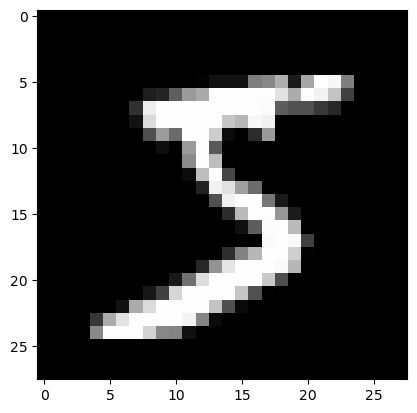

In [43]:
plt.imshow(image1, cmap='gray')


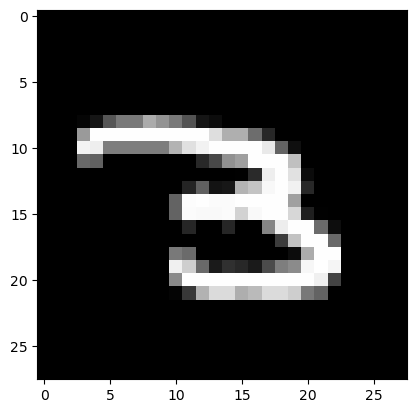

In [44]:
plt.imshow(image2, cmap='gray')

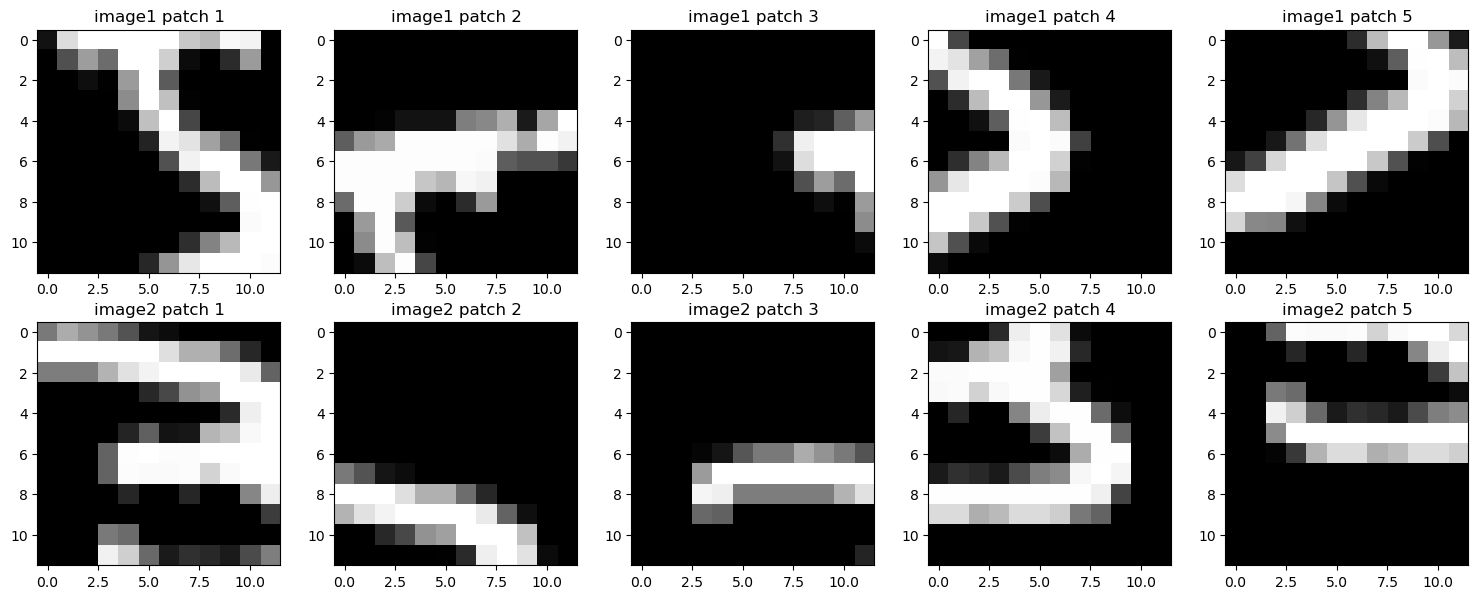

In [45]:
show_patches(patches1, patches2)

In [46]:
print("Wasserstein distance between the two ensembles of patches : ", compute_wasserstein_distance(patches1, patches2, nb_patches, patch_size))

Wasserstein distance between the two ensembles of patches :  4.267930124284358


 The two cells above are one element of our dataset, i.e two sets of patches taken in images of the dataset and the wassertein distance between these two patches distributions. 
 

# Building the networks


## Basic network without reconstruction 

2 convolution layers, embedding size = 50

In [47]:
class Network(nn.Module): 
    def __init__(self, patch_size = patch_size, embedding_size=50): 
        super(Network, self).__init__()
    
        
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=20, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, padding=2)  # Conv2D with 5 filters, 5x5 kernel
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(30*patch_size**2, 100)  # Flatten layer and Dense layer with 100 units
        self.fc2 = nn.Linear(100, embedding_size)  # Dense layer with embedding_size units
        
    def forward_one(self, x): 
        x =F.relu(self.conv1(x))
        x =F.relu(self.conv2(x))
        x= self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
    def forward(self, input1, input2):
        # Forward pass pour les deux distributions, (embedding)
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)

        
        return output1, output2
    


## Biger network without reconstruction 

4 convolution layers, embedding size = 100

In [48]:
class Network2(nn.Module): 
    def __init__(self, patch_size = patch_size, embedding_size=100): 
        super(Network2, self).__init__()
    
        
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=2)  # Conv2D with 5 filters, 5x5 kernel
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=5, padding=2)
        

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(40*patch_size**2, 200)  # Flatten layer and Dense layer with 100 units
        self.fc2 = nn.Linear(200, embedding_size)  # Dense layer with embedding_size units
        
    def forward_one(self, x): 
        x =F.relu(self.conv1(x))
        x =F.relu(self.conv2(x))
        x =F.relu(self.conv3(x))
        x= self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
    def forward(self, input1, input2):
        # Forward pass pour les deux distributions, (embedding)
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)

        
        return output1, output2
    


## Network with reconstruction 

Same network as Courty et al, 2017 (https://arxiv.org/abs/1710.07457)

In [49]:
class Autoencoder(nn.Module): 
    def __init__(self, patch_size = patch_size): 
        super(Autoencoder, self).__init__()
    
        self.embedding_size= 50

        self.conv1 = nn.Conv2d(in_channels=5, out_channels=20, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, padding=2)  # Conv2D with 5 filters, 5x5 kernel
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(30*patch_size**2, 100)  # Flatten layer and Dense layer with 100 units
        self.fc2 = nn.Linear(100, self.embedding_size)  # Dense layer with embedding_size units


        # Couches pour la reconstruction
        self.fc3 = nn.Linear(self.embedding_size, 100)
        self.fc4 = nn.Linear(100, 30 * patch_size**2)
        self.unflatten = nn.Unflatten(1, (30, patch_size, patch_size))
        self.deconv1 = nn.Conv2d(in_channels=30, out_channels=20, kernel_size=5, padding=2)
        self.deconv2 = nn.Conv2d(in_channels=20, out_channels=5, kernel_size=3, padding=1)
        

        
    def forward_one(self, x): 
        x =F.relu(self.conv1(x))
        x =F.relu(self.conv2(x))
        x= self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
    def reconstruct(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.unflatten(x)
        x = F.relu(self.deconv1(x))
        x = self.deconv2(x)
        reconstructed = F.log_softmax(x, dim=1)  # Softmax activation function


        return reconstructed
    
    def forward(self, input1, input2):
        # Forward pass pour les deux distributions, (embedding)
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        reconstructed1 = self.reconstruct(output1)
        reconstructed2 = self.reconstruct(output2)

        return output1, output2, reconstructed1, reconstructed2
    


In [50]:
# Custom Loss for the autoencoder
#It is a combination of the MSE loss and the kulback leibler divergence
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.9):
        super(CustomLoss, self).__init__()
        self.alpha = alpha

    def forward(self, batch1, batch2, output1, output2, reconstructed1, reconstructed2, batch_size, nb_patches, patch_size):
        # Calculate the mean squared error betwen the euclidean distance (between the embeddings) and the wasserstein distance (between the patches)

        wasserstein_dist= torch.zeros(batch_size)

        for j in range(batch_size): 
            wasserstein_dist[j]= compute_wasserstein_distance(batch1[j], batch2[j],nb_patches, patch_size)

        euclidean_dist = compute_euclidean_dist(output1, output2)

        MSEloss = nn.MSELoss()(euclidean_dist, wasserstein_dist)

        # Calculate the reconstruction loss, with the KL divergence
        epsilon = 1e-10
        kl_div1 = F.kl_div(reconstructed1+ epsilon, batch1+epsilon, reduction='batchmean')
        kl_div2 = F.kl_div(reconstructed2 + epsilon, batch2 + epsilon, reduction='batchmean')

        print(f'MSE loss : {self.alpha*MSEloss}')
        print(f'KL divergence : {(1 - self.alpha)*(kl_div1+kl_div2)}')


        # Combine the two losses
        loss = self.alpha * MSEloss + (1 - self.alpha) * (kl_div1+kl_div2)
        
        return loss


In [57]:
siamese_net = Network()

print(siamese_net)

Network(
  (conv1): Conv2d(5, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
)


In [52]:
siamese_net2 = Network2()

print(siamese_net)

Network(
  (conv1): Conv2d(5, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
)


# Training of the networks

## Train of the simple network

In [58]:
epochs = 300
batch_size= 64

criterion = nn.MSELoss()
optimizer = optim.SGD(siamese_net.parameters(), lr=0.001)

wasserstein_dist= torch.Tensor((batch_size))

for epoch in range(epochs): 
    batch1, batch2 = generate_batch(X, batch_size, nb_patches , patch_size)

    for j in range(batch_size): 
        wasserstein_dist[j]= compute_wasserstein_distance(batch1[j], batch2[j],nb_patches, patch_size)
 
    
    output1 , ouput2 = siamese_net(batch1, batch2)

    euclidean_dist = compute_euclidean_dist(output1, ouput2)
    #print("euc dist", euclidean_dist.shape)

    loss = criterion(euclidean_dist, wasserstein_dist)
    #print("loss", loss.shape)

    loss.backward()

    optimizer.step()

    if (epoch + 1) % 10== 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    if epoch > 150: 
        optimizer = optim.SGD(siamese_net.parameters(), lr=0.0001)
    if epoch > 250: 
        optimizer = optim.SGD(siamese_net.parameters(), lr=0.00001)


Epoch [10/300], Loss: 14.9817
Epoch [20/300], Loss: 8.9558
Epoch [30/300], Loss: 1.4475
Epoch [40/300], Loss: 2.7416
Epoch [50/300], Loss: 1.4220
Epoch [60/300], Loss: 1.6396
Epoch [70/300], Loss: 1.6370
Epoch [80/300], Loss: 1.3366
Epoch [90/300], Loss: 1.3685
Epoch [100/300], Loss: 1.5386
Epoch [110/300], Loss: 0.9829
Epoch [120/300], Loss: 1.0549
Epoch [130/300], Loss: 0.9982
Epoch [140/300], Loss: 0.9220
Epoch [150/300], Loss: 0.9533
Epoch [160/300], Loss: 0.8592
Epoch [170/300], Loss: 1.2930
Epoch [180/300], Loss: 1.1777
Epoch [190/300], Loss: 0.7026
Epoch [200/300], Loss: 0.8601
Epoch [210/300], Loss: 0.9333
Epoch [220/300], Loss: 0.6229
Epoch [230/300], Loss: 0.6614
Epoch [240/300], Loss: 0.7158
Epoch [250/300], Loss: 0.8485
Epoch [260/300], Loss: 0.5989
Epoch [270/300], Loss: 0.7146
Epoch [280/300], Loss: 0.8969
Epoch [290/300], Loss: 0.6779
Epoch [300/300], Loss: 0.9653


In [20]:
epochs = 300
batch_size= 64

criterion = nn.MSELoss()
optimizer = optim.SGD(siamese_net.parameters(), lr=0.001)

# Define the learning rate scheduler
milestones = [100, 150, 200, 250]  # Epochs at which to reduce the learning rate
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)


wasserstein_dist= torch.Tensor((batch_size))

for epoch in range(epochs): 
    batch1, batch2 = generate_batch(X, batch_size, nb_patches , patch_size)

    for j in range(batch_size): 
        wasserstein_dist[j]= compute_wasserstein_distance(batch1[j], batch2[j],nb_patches, patch_size)
 
    
    output1 , ouput2 = siamese_net2(batch1, batch2)

    euclidean_dist = compute_euclidean_dist(output1, ouput2)
 

    loss = criterion(euclidean_dist, wasserstein_dist)

    loss.backward()

    optimizer.step()

    scheduler.step()


    if (epoch + 1) % 10== 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')
   

Epoch [10/300], Loss: 14.9964
Learning rate: 0.0010
Epoch [20/300], Loss: 11.4082
Learning rate: 0.0010
Epoch [30/300], Loss: 6.3266
Learning rate: 0.0010
Epoch [40/300], Loss: 1.5964
Learning rate: 0.0010
Epoch [50/300], Loss: 1.7290
Learning rate: 0.0010
Epoch [60/300], Loss: 2.1068
Learning rate: 0.0010
Epoch [70/300], Loss: 1.7322
Learning rate: 0.0010
Epoch [80/300], Loss: 1.2752
Learning rate: 0.0010
Epoch [90/300], Loss: 1.1747
Learning rate: 0.0010
Epoch [100/300], Loss: 1.4137
Learning rate: 0.0001
Epoch [110/300], Loss: 1.3733
Learning rate: 0.0001
Epoch [120/300], Loss: 1.6205
Learning rate: 0.0001
Epoch [130/300], Loss: 1.1720
Learning rate: 0.0001
Epoch [140/300], Loss: 1.3034
Learning rate: 0.0001
Epoch [150/300], Loss: 1.0563
Learning rate: 0.0000
Epoch [160/300], Loss: 1.1865
Learning rate: 0.0000
Epoch [170/300], Loss: 0.9242
Learning rate: 0.0000
Epoch [180/300], Loss: 1.5093
Learning rate: 0.0000
Epoch [190/300], Loss: 0.9733
Learning rate: 0.0000
Epoch [200/300], Lo

## Training of the network with reconstruction loss

In [85]:
network_reconstruction = Autoencoder()

print(network_reconstruction)

Autoencoder(
  (conv1): Conv2d(5, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=4320, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(30, 12, 12))
  (deconv1): Conv2d(30, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (deconv2): Conv2d(20, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [50]:
# test forward pass

batch_size= 8

x1, x2 = generate_batch(X, batch_size, nb_patches, patch_size)

print(f'shape input 1 : {x1.shape}, shape input 2 :  {x1.shape}')

#feed these two test batches into the model
o1, o2, r1, r2  = network_reconstruction(x1, x1)

print(f'output1 shape: {o1.shape}, output2 shape :{o2.shape}')


print(f'reconstruted 1 shape: {r1.shape}, reconstructed 2 shape :{r2.shape}')

#show_patches(r1[0].detach().numpy(), r2[0].detach().numpy())

shape input 1 : torch.Size([8, 5, 12, 12]), shape input 2 :  torch.Size([8, 5, 12, 12])


NameError: name 'network_reconstruction' is not defined

In [86]:
epochs = 200
batch_size= 32

criterion = CustomLoss(alpha = 0.001)
optimizer = optim.Adam(network_reconstruction.parameters(), lr=0.0001)

wasserstein_dist= torch.Tensor((batch_size))

for epoch in range(epochs): 
    batch1, batch2 = generate_batch(X, batch_size, nb_patches , patch_size)
    
    output1 , ouput2, reconstructed1, reconstructed2 = network_reconstruction(batch1, batch2)

    loss = criterion(batch1, batch2, output1, ouput2, reconstructed1, reconstructed2, batch_size, nb_patches, patch_size)

    #print("loss", loss.shape)

    loss.backward()

    optimizer.step()

    if (epoch + 1) % 10== 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


MSE loss : 322.22662353515625
KL divergence : 275.525634765625
MSE loss : 256.5093688964844
KL divergence : 276.8621826171875
MSE loss : 221.4722442626953
KL divergence : 266.0223388671875
MSE loss : 168.5369110107422
KL divergence : 271.33734130859375
MSE loss : 163.17344665527344
KL divergence : 256.0872802734375
MSE loss : 102.16358947753906
KL divergence : 260.266357421875
MSE loss : 128.0011749267578
KL divergence : 256.13262939453125
MSE loss : 82.10877227783203
KL divergence : 266.8487548828125
MSE loss : 71.9703140258789
KL divergence : 261.2278137207031
MSE loss : 86.3739013671875
KL divergence : 254.36541748046875
Epoch [10/200], Loss: 254.1974
MSE loss : 58.94737243652344
KL divergence : 274.7969970703125


KeyboardInterrupt: 

# Test of the performances 

In [58]:
range_test = np.linspace(1, 5000, 10, dtype=int)




In [59]:

times_pot = []
times_nn = []


for size in range_test:
    print(f'Computing time for batch size {size}')
    test_batch_size = size.astype(int)
    test1, test2 = generate_batch(X, test_batch_size, nb_patches, patch_size)
    label_wsr = np.zeros((test_batch_size))



    start_time = time.time()

    for i in range(test_batch_size):
        label_wsr[i] = compute_wasserstein_distance(test1[i], test2[i], nb_patches, patch_size)

    end_time = time.time()

    time_pot = end_time - start_time
    times_pot.append(time_pot)
    print(f'Pot time : {time_pot}')


    start_time = time.time()

    emb1, emb2 = siamese_net(test1, test2)
    pred_wsr = compute_euclidean_dist(emb1, emb2)


    end_time = time.time()

    time_nn = end_time - start_time
    times_nn.append(time_nn)
    print(f'NN time : {time_nn}')




Computing time for batch size 1
Pot time : 0.0009982585906982422
NN time : 0.03292226791381836
Computing time for batch size 556
Pot time : 0.4925215244293213
NN time : 0.2204113006591797
Computing time for batch size 1111
Pot time : 0.6037585735321045
NN time : 0.24741625785827637
Computing time for batch size 1667
Pot time : 0.88153076171875
NN time : 0.40448951721191406
Computing time for batch size 2222
Pot time : 1.1883556842803955
NN time : 0.5658245086669922
Computing time for batch size 2778
Pot time : 1.4541423320770264
NN time : 0.6197969913482666
Computing time for batch size 3333
Pot time : 1.8824589252471924
NN time : 0.7637944221496582
Computing time for batch size 3889
Pot time : 2.034459114074707
NN time : 0.9166278839111328
Computing time for batch size 4444
Pot time : 2.298823833465576
NN time : 1.007120132446289
Computing time for batch size 5000
Pot time : 2.6215415000915527
NN time : 1.1158177852630615


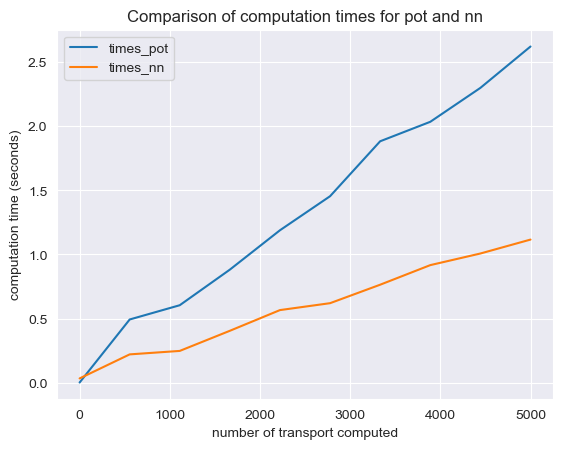

In [61]:
# Plotting
plt.plot(range_test, times_pot, label='times_pot')
plt.plot(range_test, times_nn, label='times_nn')

# Adding labels and legend
plt.xlabel('number of transport computed')  
plt.ylabel('computation time (seconds)')  # Replace with an appropriate label for the y-axis
plt.title('Comparison of computation times for pot and nn')
plt.legend()

# Display the plot
plt.show()

In [59]:
test_batch_size = 100


test1, test2 = generate_batch(X, test_batch_size, nb_patches, patch_size)
label_wsr = np.zeros((test_batch_size))



In [60]:
start_time = time.time()

for i in range(test_batch_size):
    label_wsr[i] = compute_wasserstein_distance(test1[i], test2[i], nb_patches, patch_size)

end_time = time.time()

time_pot = end_time - start_time

print(f'POT Wasserstein distance computation time : {end_time - start_time} seconds')


POT Wasserstein distance computation time : 0.19877982139587402 seconds


In [61]:
start_time = time.time()

emb1, emb2 = siamese_net(test1, test2)
pred_wsr = compute_euclidean_dist(emb1, emb2)


end_time = time.time()

time_nn = end_time - start_time

print(f'Neural network computation time : {end_time - start_time} seconds')



Neural network computation time : 0.08245611190795898 seconds


In [62]:
# Mean error between the predicted wasserstein distance and the real wasserstein distance
error = abs(pred_wsr.detach().numpy()-label_wsr).mean()

# standard deviation of the error
std = abs(pred_wsr.detach().numpy()-label_wsr).std()

print("mean error =  ", error)
print("standard deviation = ", std)


mean error =   0.7213299293518065
standard deviation =  0.5368959419140722


In [63]:
# show the first predicted wasserstein distances and the true wasserstein distances

for i in range(batch_size//4):
    print("Wasserstein distance predicted : ", pred_wsr[i].item())
    print("True Wasserstein distance", label_wsr[i])
print("....")




Wasserstein distance predicted :  3.669092893600464
True Wasserstein distance 3.7738123416900633
Wasserstein distance predicted :  2.4657113552093506
True Wasserstein distance 3.9548027992248533
Wasserstein distance predicted :  3.066206455230713
True Wasserstein distance 3.6543036460876466
Wasserstein distance predicted :  4.004211902618408
True Wasserstein distance 4.47487621307373
Wasserstein distance predicted :  5.290560722351074
True Wasserstein distance 4.325824403762818
Wasserstein distance predicted :  2.7225077152252197
True Wasserstein distance 3.979719400405884
Wasserstein distance predicted :  5.034512996673584
True Wasserstein distance 4.770877361297607
Wasserstein distance predicted :  3.5163004398345947
True Wasserstein distance 4.441598749160767
Wasserstein distance predicted :  3.389476776123047
True Wasserstein distance 3.126925086975098
Wasserstein distance predicted :  3.8605761528015137
True Wasserstein distance 3.947189235687256
Wasserstein distance predicted :  